In [181]:
maxSegments=            6
spikeThreshold=         0.9
vertexCountOvershoot=   2
preventOneYearRecovery = True
recoveryThreshold=      0.25
minObservationsNeeded=  6

In [182]:
def adjust_duplicates(lst):
    lst = [round(num) for num in lst]
    max_value = lst[-1]  # Giá trị lớn nhất ban đầu trong danh sách
    i = 0
    while i < len(lst) - 1:
        # Nếu phần tử hiện tại trùng với phần tử tiếp theo
        if lst[i] == lst[i + 1]:
            lst[i] += 1  # Cộng thêm 1 cho phần tử hiện tại
            
            # Kiểm tra nếu giá trị mới lớn hơn max_value, loại bỏ phần tử
            if lst[i] > max_value:
                lst.pop(i)
                i -= 1  # Điều chỉnh chỉ số để không bỏ qua phần tử nào
            else:
                lst.sort()
                i -= 1
        i += 1
    return lst

In [183]:
import pandas as pd

# Đường dẫn đến tệp dữ liệu CSV
file_path = 'Pixel_TimeSeries_Export.csv'

# Đọc tệp CSV vào DataFrame
data = pd.read_csv(file_path)
data = data.dropna()

# Loại bỏ các cột không cần thiết
data = data.drop(columns=['date'])
data.reset_index(drop=True, inplace=True)
# data['date'] = pd.to_datetime(data['date'])

In [184]:
import xarray as xr

ds = xr.Dataset(
    {
        "NBR": (["time"], data['NBR'])
    },
    coords={
        "time": data.index
    }
)

Bước 1: Hồi quy phân đoạn

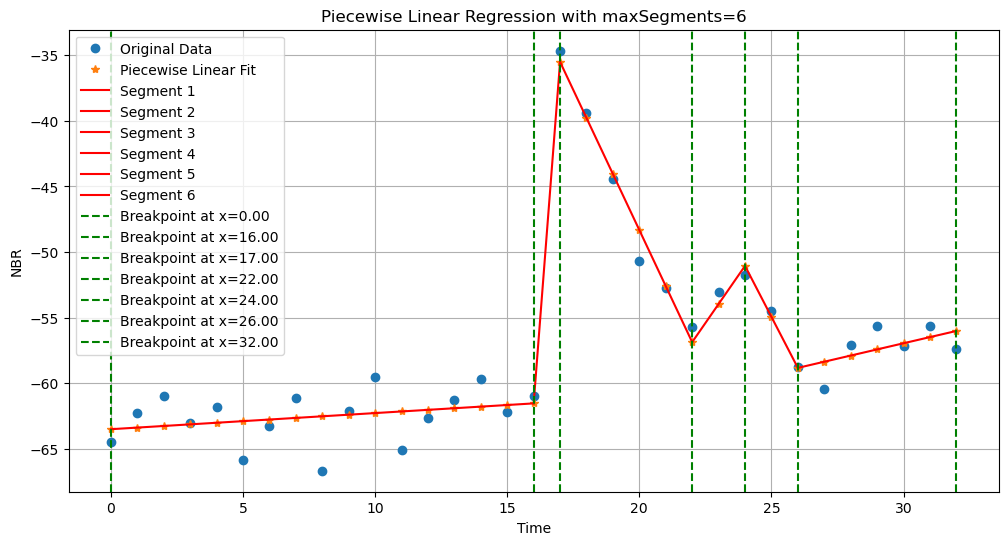

In [185]:
import pwlf
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
# Giả sử bạn đã có dataset xarray 'ds' từ các bước trước

# Trích xuất dữ liệu từ xarray: thời gian và giá trị NBR
time_numeric = ds['time'].values
nbr_values = ds['NBR'].values  # Giá trị NBR
nbr_min = np.min(nbr_values)
nbr_max = np.max(nbr_values)
time_min = np.min(time_numeric)
time_max = np.max(time_numeric)
nbr_values = nbr_values / (nbr_max - nbr_min) * (time_max - time_min)
# Thực hiện hồi quy phân đoạn với pwlf
my_pwlf = pwlf.PiecewiseLinFit(time_numeric, nbr_values)

# Phân đoạn với tối đa 6 đoạn (maxSegments = 6)
breakpoints = my_pwlf.fit(maxSegments)
breakpoints = adjust_duplicates(breakpoints)
my_pwlf.fit_with_breaks(breakpoints)

# Dự đoán giá trị NBR dựa trên hồi quy phân đoạn
predicted_NBR = my_pwlf.predict(time_numeric)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, nbr_values, 'o', label='Original Data')  # Dữ liệu gốc từ xarray
plt.plot(time_numeric, predicted_NBR, '*', label='Piecewise Linear Fit')  # Dữ liệu hồi quy

for i in range(1, len(breakpoints)):
    # Lấy đoạn x trong khoảng từ breakpoint trước đến breakpoint sau
    x_segment = np.linspace(breakpoints[i-1], breakpoints[i], num=100)
    
    # Dự đoán giá trị y tương ứng với đoạn x đó
    y_segment = my_pwlf.predict(x_segment)
    
    # Vẽ đoạn hồi quy trên đồ thị
    plt.plot(x_segment, y_segment, '-', label=f'Segment {i}', color='red')

for bp in breakpoints:
    plt.axvline(x=bp, linestyle='--', color='green', label=f'Breakpoint at x={bp:.2f}')
plt.title('Piecewise Linear Regression with maxSegments=6')
plt.xlabel('Time')
plt.ylabel('NBR')
plt.legend()
plt.grid()
plt.show()

In [186]:
np.std(ds['NBR'].values)

94.76094525932155

Bước 2: Làm mịn bất thường

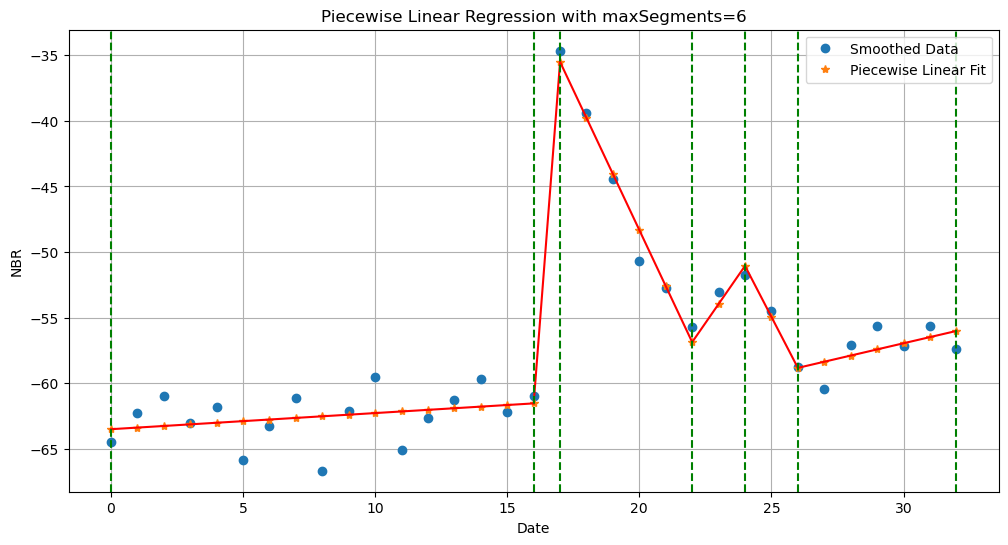

In [187]:
def smooth_spikes(nbr_values, spike_threshold=spikeThreshold):
    smoothed_values = nbr_values.copy()
    for i in range(1, len(nbr_values) - 1):
        if nbr_values[i] != 0:
            # Tính tỷ lệ thay đổi giữa giá trị hiện tại và giá trị trước/sau
            spike_ratio_before = abs(nbr_values[i] - nbr_values[i-1]) / abs(nbr_values[i-1])
            spike_ratio_after = abs(nbr_values[i+1] - nbr_values[i]) / abs(nbr_values[i+1])
            # Kiểm tra nếu cả hai sự thay đổi đều vượt ngưỡng spikeThreshold
            if spike_ratio_before >= spike_threshold and spike_ratio_after >= spike_threshold:
                print(f"Phát hiện bất thường đột ngột tại điểm {i}, lấy trung bình cộng hai điểm {i+1} và {i-1}")
                # Làm mịn bằng cách thay thế giá trị đột biến bằng trung bình lân cận
                smoothed_values[i] = (nbr_values[i-1] + nbr_values[i+1]) / 2
    return smoothed_values


smoothed_nbr_values = smooth_spikes(nbr_values)
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, smoothed_nbr_values, 'o', label='Smoothed Data')  # Dữ liệu đã làm mịn
plt.plot(time_numeric, predicted_NBR, '*', label='Piecewise Linear Fit')  # Dữ liệu hồi quy
for i in range(1, len(breakpoints)):
    x_segment = np.linspace(breakpoints[i-1], breakpoints[i], num=100)
    y_segment = my_pwlf.predict(x_segment)
    plt.plot(x_segment, y_segment, '-', color='red')

# Vẽ các đường thẳng tại các breakpoints
for bp in breakpoints:
    plt.axvline(x=bp, linestyle='--', color='green')


plt.title('Piecewise Linear Regression with maxSegments=6')
plt.xlabel('Date')
plt.ylabel('NBR')
plt.legend()
plt.grid()
plt.show()


Bước 3: Hồi quy lượt 2 với dữ liệu sau làm mịn và oververtex

In [188]:
my_pwlf = pwlf.PiecewiseLinFit(time_numeric, smoothed_nbr_values)

vertex_count_overshoot = vertexCountOvershoot
overshoot_segments = maxSegments + vertex_count_overshoot
overshoot_breakpoints = my_pwlf.fit(overshoot_segments)
print(overshoot_breakpoints)

overshoot_breakpoints = adjust_duplicates(overshoot_breakpoints)
my_pwlf.fit_with_breaks(overshoot_breakpoints)

[ 0.          7.99999999 16.18587376 16.44862585 21.53526849 24.20182423
 26.6635674  28.41594823 32.        ]


67.68693569524567

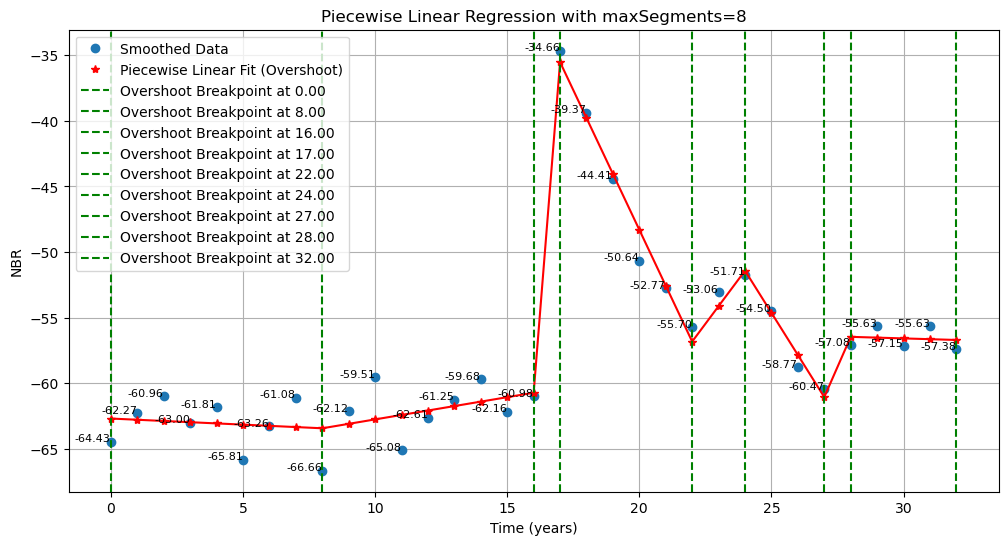

In [189]:
predicted_NBR_overshoot = my_pwlf.predict(time_numeric)
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, smoothed_nbr_values, 'o', label='Smoothed Data')  # Dữ liệu đã làm mịn
for i, (x, y) in enumerate(zip(time_numeric, smoothed_nbr_values)):
    plt.text(x, y, f'{y:.2f}', fontsize=8, ha='right')  # Hiển thị giá trị NBR bên cạnh mỗi điểm
plt.plot(time_numeric, predicted_NBR_overshoot, '*', label='Piecewise Linear Fit (Overshoot)', color='red')  # Dữ liệu hồi quy sau khi thêm overshoot

for i in range(1, len(breakpoints)):
    x_segment = np.linspace(breakpoints[i-1], breakpoints[i], num=100)
    y_segment = my_pwlf.predict(x_segment)
    plt.plot(x_segment, y_segment, '-', color='red')

# Vẽ các đường thẳng tại các breakpoints
for bp in overshoot_breakpoints:
    plt.axvline(x=bp, linestyle='--', color='green', label=f'Overshoot Breakpoint at {bp:.2f}')

# Các chi tiết về biểu đồ
plt.title(f'Piecewise Linear Regression with maxSegments={overshoot_segments}')
plt.xlabel('Time (years)')
plt.ylabel('NBR')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
import math

# Hàm tính góc giữa hai đoạn thẳng từ độ dốc
def calculate_angle_between_slopes(m1, m2):    
    # Tính cos của góc giữa hai vector
    cos_theta = abs((1 + m1 * m2) / (math.sqrt(1**2 + m1**2) * math.sqrt(1**2 + m2**2)))
    # Tính góc giữa hai vector bằng arccos
    return math.degrees(math.acos(cos_theta))


Bước 4: Lọc các đỉnh với tiêu chí cụ thể, góc, khoảng cách nbr, phương sai tổng.

In [191]:
def dynamic_thresholds(slopes, nbr_values, nbr_percentile):
    result = {}  # Dictionary lưu kết quả
    for i in range(len(slopes) - 1):  # Lặp qua các slope[i] và slope[i+1]
        theta = calculate_angle_between_slopes(slopes[i], slopes[i+1])
        print(f"đoạn {i} góc {theta}")
        # Thêm giá trị vào dictionary với khóa là i (hoặc i+1)
        result[i] = {'slope': slopes[i], 'slope_next': slopes[i+1], 'theta': theta}
    nbr_diff = np.abs(np.diff(nbr_values))  # Tính sự thay đổi giữa các giá trị NBR
    nbr_threshold = np.percentile(nbr_diff, nbr_percentile)
    
    return result, nbr_threshold

In [192]:

def filter_breakpoints_dynamic(breakpoints, slopes, nbr_values, n_segments = maxSegments):
    # Tính toán các ngưỡng động
    std_dev = np.std(nbr_values)  # Tính độ lệch chuẩn của chuỗi NBR
    nbr_percentile = max(20, 70 - 10 * n_segments * (std_dev / (0.5*(len(nbr_values)-1))))
    
    # Đảm bảo `nbr_percentile` nằm trong khoảng hợp lý (25 đến 75)
    nbr_percentile = min(nbr_percentile, 60)

    print(std_dev, nbr_percentile)
    slope_threshol_result, nbr_threshold = dynamic_thresholds(slopes, nbr_values, nbr_percentile)
    
    filtered_breakpoints = [breakpoints[0]]  # Giữ lại điểm đầu tiên
    
    for i in range(1, len(breakpoints) - 1):
        
        # Tính sự thay đổi NBR
        delta_nbr_after = abs(nbr_values[breakpoints[i]+1] - my_pwlf.predict(breakpoints[i])[0])
        delta_nbr_before = abs(nbr_values[breakpoints[i]-1] - my_pwlf.predict(breakpoints[i])[0])
        
        # Kiểm tra xem có vượt ngưỡng động không
        if (delta_nbr_after > nbr_threshold or delta_nbr_before > nbr_threshold) and (((slope_threshol_result[i-1]['slope'] * slope_threshol_result[i-1]['slope_next']) < 0) or ((slope_threshol_result[i-1]['slope'] * slope_threshol_result[i-1]['slope_next']) >= 0 and slope_threshol_result[i-1]['theta'] >= 30)) :
            print(i, slope_threshol_result[i-1]['slope'], slope_threshol_result[i-1]['slope_next'], slope_threshol_result[i-1]['theta'])
            filtered_breakpoints.append(breakpoints[i])
    
    # Giữ lại điểm cuối cùng
    filtered_breakpoints.append(breakpoints[-1])
    
    return filtered_breakpoints

In [193]:
slopes = my_pwlf.slopes
filtered_breakpoints = filter_breakpoints_dynamic(overshoot_breakpoints, slopes, smoothed_nbr_values)
filtered_breakpoints

7.105181415775587 43.35556969084155
đoạn 0 góc 24.000377650749897
đoạn 1 góc 69.02512090472588
đoạn 2 góc 15.48894722562651
đoạn 3 góc 33.52831682765375
đoạn 4 góc 37.60905975647631
đoạn 5 góc 29.58267308911069
đoạn 6 góc 81.11215663185129
1 -0.09274754462892609 0.3385103875223301 24.000377650749897
2 0.3385103875223301 25.189620167335157 69.02512090472588
3 25.189620167335157 -4.258318960407347 15.48894722562651
4 -4.258318960407347 2.701502894646193 33.52831682765375
5 2.701502894646193 -3.211359774039515 37.60905975647631
6 -3.211359774039515 4.591662512250188 29.58267308911069
7 4.591662512250188 -0.05938510773692762 81.11215663185129


[0, 8, 16, 17, 22, 24, 27, 28, 32]

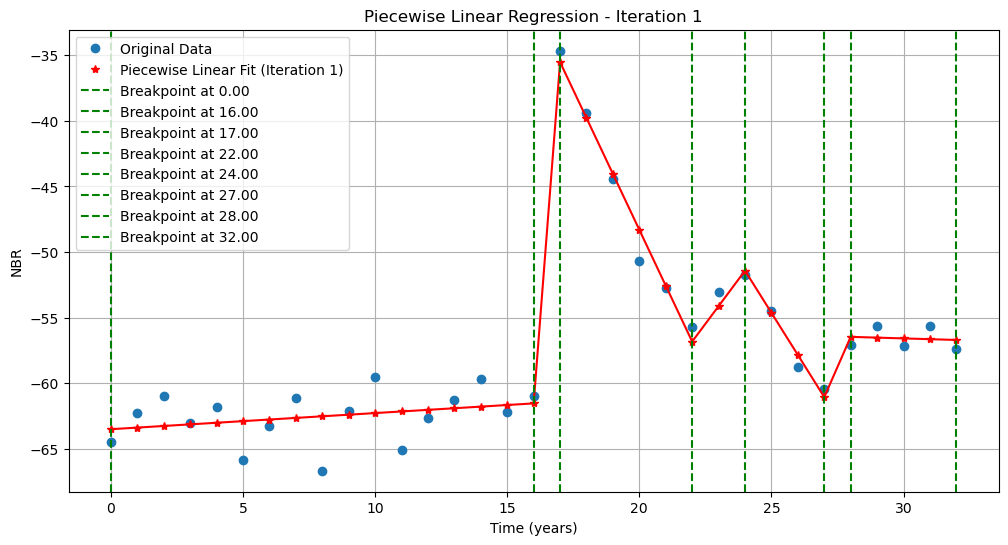

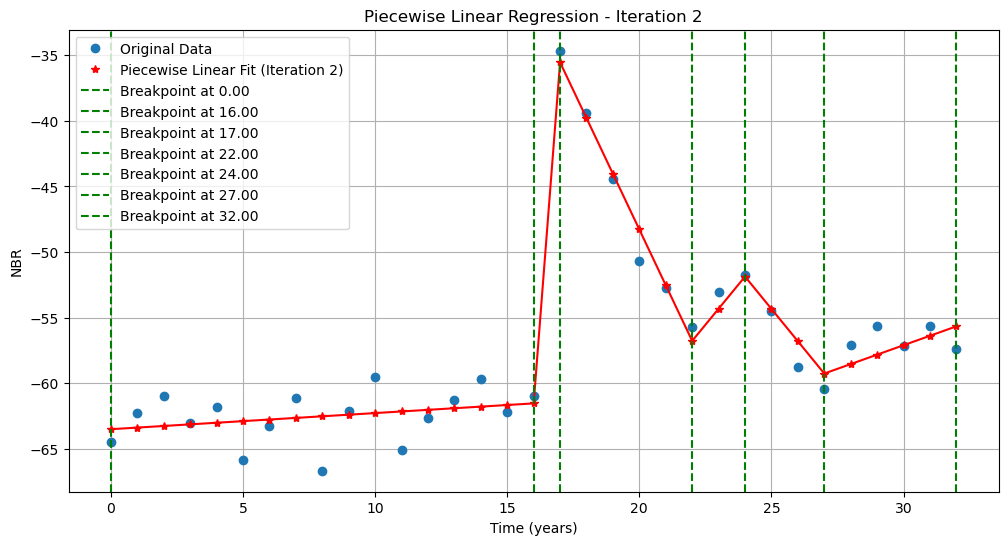

Các điểm gãy khúc lựa chọn cuối cùng [0, 16, 17, 22, 24, 27, 32]


In [194]:
def calculate_variance(y_true, y_pred):
    """
    Tính phương sai giữa giá trị thực và giá trị dự đoán.
    """
    return np.mean((y_true - y_pred) ** 2)


def plot_regression(time_numeric, nbr_values, y_pred, breakpoints, iteration, my_pwlf):
    """
    Vẽ biểu đồ hồi quy phân đoạn và các đỉnh breakpoints.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_numeric, nbr_values, 'o', label='Original Data')  # Dữ liệu gốc
    plt.plot(time_numeric, y_pred, '*', label=f'Piecewise Linear Fit (Iteration {iteration})', color='red')  # Hồi quy phân đoạn
    
    for i in range(1, len(breakpoints)):
        x_segment = np.linspace(breakpoints[i-1], breakpoints[i], num=100)
        y_segment = my_pwlf.predict(x_segment)
        plt.plot(x_segment, y_segment, '-', color='red')

    # Vẽ các breakpoints
    for bp in breakpoints:
        plt.axvline(x=bp, linestyle='--', color='green', label=f'Breakpoint at {bp:.2f}')
    
    plt.title(f'Piecewise Linear Regression - Iteration {iteration}')
    plt.xlabel('Time (years)')
    plt.ylabel('NBR')
    plt.legend()
    plt.grid(True)
    plt.show()


def remove_breakpoint_with_max_variance(breakpoints, time_numeric, nbr_values, max_segments):
    """
    Loại bỏ đỉnh gây ra sự gia tăng phương sai lớn nhất bằng cách sử dụng pwlf và vẽ biểu đồ.
    """
    iteration = 1  # Biến để đếm số lần lặp
    while len(breakpoints) > max_segments + 1:  # Cộng 1 vì giữ điểm đầu và cuối
        variances = []
        
        # Duyệt qua tất cả các đỉnh, bỏ từng đỉnh một và tính phương sai
        for i in range(1, len(breakpoints) - 1):  # Bỏ qua đỉnh đầu và cuối
            # Tạo danh sách breakpoints sau khi loại bỏ đỉnh thứ i
            temp_breakpoints = breakpoints[:i] + breakpoints[i+1:]
            
            # Sử dụng pwlf để thực hiện hồi quy phân đoạn với breakpoints tạm thời
            my_pwlf = pwlf.PiecewiseLinFit(time_numeric, nbr_values)
            my_pwlf.fit_with_breaks(temp_breakpoints)
            
            # Dự đoán giá trị NBR sau khi hồi quy
            y_pred = my_pwlf.predict(time_numeric)

            # Tính phương sai giữa giá trị thực và giá trị dự đoán
            total_variance = calculate_variance(nbr_values, y_pred)
            
            # Lưu lại phương sai khi loại đỉnh thứ i
            variances.append(total_variance)
        
        # Tìm đỉnh có phương sai nhỏ nhất và loại bỏ
        max_variance_idx = np.argmin(variances) + 1  # Cộng 1 vì bỏ qua đỉnh đầu
        
        # Loại bỏ đỉnh này khỏi danh sách breakpoints
        del breakpoints[max_variance_idx]
        
        # Vẽ biểu đồ sau khi loại bỏ đỉnh
        my_pwlf = pwlf.PiecewiseLinFit(time_numeric, nbr_values)
        my_pwlf.fit_with_breaks(breakpoints)
        y_pred = my_pwlf.predict(time_numeric)
        plot_regression(time_numeric, nbr_values, y_pred, breakpoints, iteration, my_pwlf)
        
        # Tăng biến đếm lần lặp
        iteration += 1
    
    return breakpoints

# Gọi hàm để giảm số lượng đỉnh và giữ lại breakpoints
final_breakpoints = remove_breakpoint_with_max_variance(filtered_breakpoints, time_numeric, smoothed_nbr_values, maxSegments)

# Xem kết quả
print(f"Các điểm gãy khúc lựa chọn cuối cùng {final_breakpoints}")

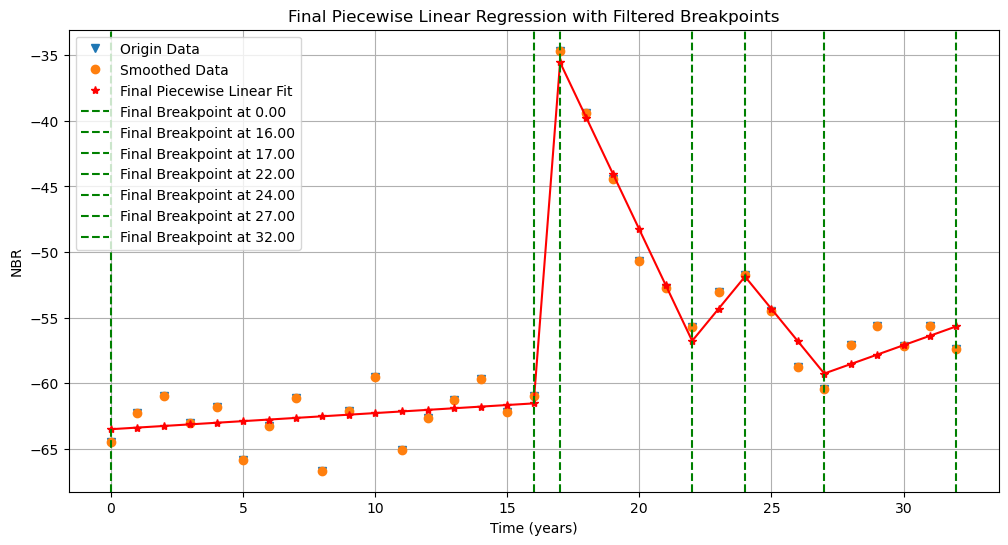

In [195]:
my_pwlf = pwlf.PiecewiseLinFit(time_numeric, smoothed_nbr_values)

# Thực hiện hồi quy phân đoạn với các final_breakpoints đã lọc
my_pwlf.fit_with_breaks(final_breakpoints)

# Dự đoán giá trị sau khi hồi quy với các đỉnh đã lọc
final_predicted_values = my_pwlf.predict(time_numeric)

# Vẽ biểu đồ kết quả cuối cùng
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, nbr_values, 'v', label='Origin Data')  # Dữ liệu gốc
plt.plot(time_numeric, smoothed_nbr_values, 'o', label='Smoothed Data')  # Dữ liệu gốc sau khi làm mịn
plt.plot(time_numeric, final_predicted_values, '*', label='Final Piecewise Linear Fit', color='red')  # Kết quả hồi quy cuối cùng

for i in range(1, len(final_breakpoints)):
    x_segment = np.linspace(final_breakpoints[i-1], final_breakpoints[i], num=100)
    y_segment = my_pwlf.predict(x_segment)
    plt.plot(x_segment, y_segment, '-', color='red')

# Vẽ các breakpoints cuối cùng
for bp in final_breakpoints:
    plt.axvline(x=bp, linestyle='--', color='green', label=f'Final Breakpoint at {bp:.2f}')

plt.title('Final Piecewise Linear Regression with Filtered Breakpoints')
plt.xlabel('Time (years)')
plt.ylabel('NBR')
plt.legend()
plt.grid(True)
plt.show()

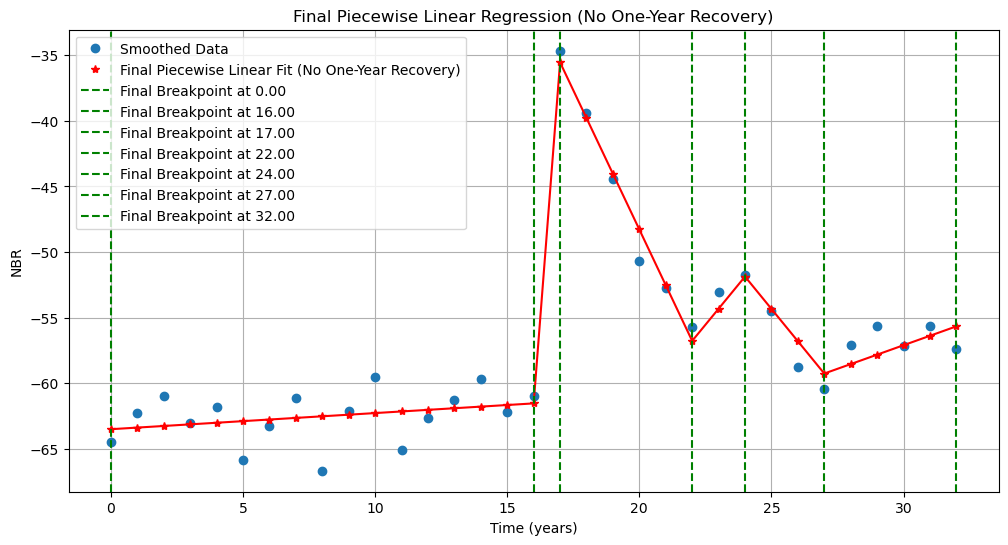

In [196]:
def detect_and_remove_short_term_recovery(breakpoints, slopes):
    filtered_breakpoints = [breakpoints[0]]  # Giữ lại điểm đầu tiên
    
    for i in range(1, len(breakpoints)-1):
        # Tính thời gian giữa các điểm breakpoints
        duration = breakpoints[i+1] - breakpoints[i]
        recovery_speed = (my_pwlf.predict(breakpoints[i+1]) - my_pwlf.predict(breakpoints[i])) / (my_pwlf.predict(breakpoints[i-1]) - my_pwlf.predict(breakpoints[i]))
        # Phát hiện phục hồi (độ dốc dương) và kiểm tra thời gian phục hồi
        if (slopes[i-1] < 0 and slopes[i] > 0) and (0.9 <= recovery_speed <= 1.2) and duration <= 1:
            print(f"Loại bỏ phục hồi ngắn hạn (1 năm) tại breakpoint {i}: thời gian {duration} năm, độ dốc {slopes[i]:.2f}")
            continue  # Bỏ qua điểm phục hồi ngắn hạn này
        filtered_breakpoints.append(breakpoints[i])
    
    # Giữ lại điểm cuối cùng
    filtered_breakpoints.append(breakpoints[-1])
    
    return filtered_breakpoints

slopes = my_pwlf.slopes
final_breakpoints_no_recovery = detect_and_remove_short_term_recovery(final_breakpoints, slopes)

# Thực hiện hồi quy phân đoạn với các breakpoints đã lọc
my_pwlf.fit_with_breaks(final_breakpoints_no_recovery)
final_predicted_values_no_recovery = my_pwlf.predict(time_numeric)

# Vẽ biểu đồ kết quả sau khi loại bỏ phục hồi ngắn hạn
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, smoothed_nbr_values, 'o', label='Smoothed Data')  # Dữ liệu gốc sau khi làm mịn
plt.plot(time_numeric, final_predicted_values_no_recovery, '*', label='Final Piecewise Linear Fit (No One-Year Recovery)', color='red')

# Vẽ các đoạn hồi quy cuối cùng
for i in range(1, len(final_breakpoints_no_recovery)):
    x_segment = np.linspace(final_breakpoints_no_recovery[i-1], final_breakpoints_no_recovery[i], num=100)
    y_segment = my_pwlf.predict(x_segment)
    plt.plot(x_segment, y_segment, '-', color='red')

# Vẽ các breakpoints cuối cùng đã lọc
for bp in final_breakpoints_no_recovery:
    plt.axvline(x=bp, linestyle='--', color='green', label=f'Final Breakpoint at {bp:.2f}')

plt.title('Final Piecewise Linear Regression (No One-Year Recovery)')
plt.xlabel('Time (years)')
plt.ylabel('NBR')
plt.legend()
plt.grid(True)
plt.show()

slope 1 0.12288142144670644 25.98247579814136
Giữ lại đoạn suy thoái giữa 16 và 17
slope 2 25.98247579814136 -4.244125955768984
Giữ lại đoạn suy thoái giữa 17 và 22
slope 3 -4.244125955768984 2.450759812701971
Giữ lại đoạn phục hồi giữa 22 và 24, mức độ phục hồi: 0.12
slope 4 2.450759812701971 -2.4626787793666742
Giữ lại đoạn suy thoái giữa 24 và 27
slope 5 -2.4626787793666742 0.7191011966765999
Giữ lại đoạn phục hồi giữa 27 và 32, mức độ phục hồi: 0.10


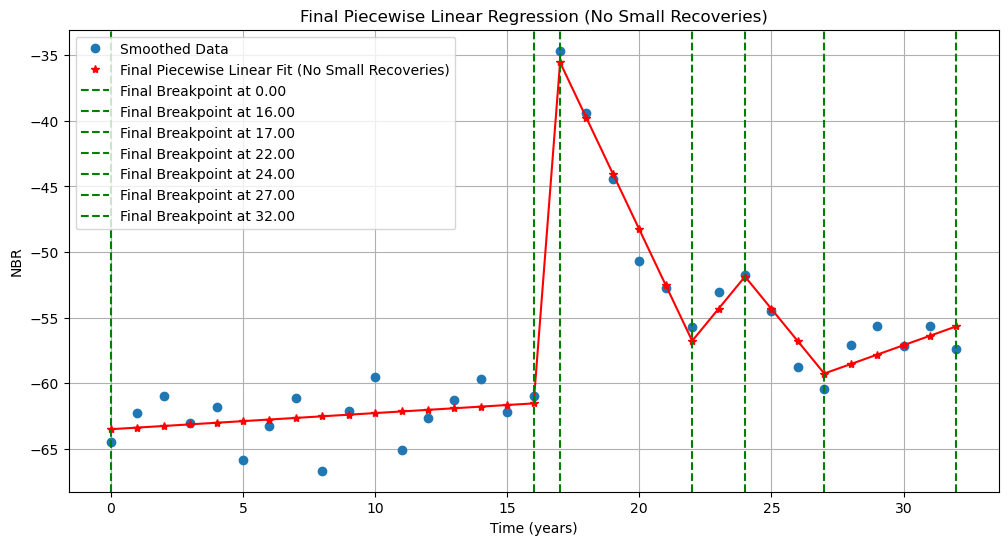

In [197]:
def detect_and_remove_small_recoveries(breakpoints, recovery_threshold=0.25):
    """
    Phát hiện và loại bỏ các phục hồi không đáng kể (nhỏ hơn recoveryThreshold).
    
    Params:
    - breakpoints: Danh sách các điểm breakpoints.
    - smoothed_nbr_values: Giá trị NBR đã làm mịn tại các điểm breakpoints.
    - recovery_threshold: Ngưỡng phục hồi tối thiểu để được coi là đáng kể.
    
    Returns:
    - filtered_breakpoints: Danh sách breakpoints đã loại bỏ các phục hồi nhỏ.
    """
    filtered_breakpoints = [breakpoints[0]]  # Giữ lại điểm đầu tiên
    
    for i in range(1, len(breakpoints)-1):
        # Kiểm tra nếu đoạn này là phục hồi và mức độ phục hồi lớn hơn ngưỡng
        print("slope", i, slopes[i-1], slopes[i])
        if (slopes[i-1] < 0 and slopes[i] > 0):
            duration = breakpoints[i+1] - breakpoints[i]
            recovery_magnitude = ((my_pwlf.predict(breakpoints[i+1])[0] - my_pwlf.predict(breakpoints[i])[0]) / duration) / (my_pwlf.predict(breakpoints[i-1])[0] - my_pwlf.predict(breakpoints[i])[0])
            if duration >= 2 and recovery_magnitude <= recovery_threshold:
                print(f"Giữ lại đoạn phục hồi giữa {breakpoints[i]} và {breakpoints[i+1]}, mức độ phục hồi: {recovery_magnitude:.2f}")
                filtered_breakpoints.append(breakpoints[i])
            elif duration >= 2 and recovery_magnitude > recovery_threshold:
                print(f"Loại bỏ đoạn phục hồi quá nhanh giữa {breakpoints[i]} và {breakpoints[i+1]}, mức độ phục hồi: {recovery_magnitude:.2f}")
            else:
                print(f"Giữ lại đoạn phục hồi giữa {breakpoints[i]} và {breakpoints[i+1]}, mức độ phục hồi: {recovery_magnitude:.2f}")
                filtered_breakpoints.append(breakpoints[i])
        else:
            # Đoạn này là đoạn suy thoái (giảm NBR), giữ lại
            print(f"Giữ lại đoạn suy thoái giữa {breakpoints[i]} và {breakpoints[i+1]}")
            filtered_breakpoints.append(breakpoints[i])
    
    # Giữ lại điểm cuối cùng
    filtered_breakpoints.append(breakpoints[-1])
    
    return filtered_breakpoints

slopes = my_pwlf.slopes
final_breakpoints_no_small_recoveries = detect_and_remove_small_recoveries(final_breakpoints_no_recovery, recovery_threshold=0.25)

# Thực hiện hồi quy phân đoạn với các breakpoints đã lọc
my_pwlf.fit_with_breaks(final_breakpoints_no_small_recoveries)
final_predicted_values_no_small_recoveries = my_pwlf.predict(time_numeric)

# Vẽ biểu đồ kết quả sau khi loại bỏ các phục hồi nhỏ
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, smoothed_nbr_values, 'o', label='Smoothed Data')  # Dữ liệu gốc sau khi làm mịn
plt.plot(time_numeric, final_predicted_values_no_small_recoveries, '*', label='Final Piecewise Linear Fit (No Small Recoveries)', color='red')

# Vẽ các đoạn hồi quy
for i in range(1, len(final_breakpoints_no_small_recoveries)):
    x_segment = np.linspace(final_breakpoints_no_small_recoveries[i-1], final_breakpoints_no_small_recoveries[i], num=100)
    y_segment = my_pwlf.predict(x_segment)
    plt.plot(x_segment, y_segment, '-', color='red')

# Vẽ các breakpoints đã lọc
for bp in final_breakpoints_no_small_recoveries:
    plt.axvline(x=bp, linestyle='--', color='green', label=f'Final Breakpoint at {bp:.2f}')

plt.title('Final Piecewise Linear Regression (No Small Recoveries)')
plt.xlabel('Time (years)')
plt.ylabel('NBR')
plt.legend()
plt.grid(True)
plt.show()